In [61]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer

# Configuration
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)

# File paths
CVE_FILES = [
    'nvdcve-1.1-2020.json',
    'nvdcve-1.1-2021.json',
    'nvdcve-1.1-2022.json',
    'nvdcve-1.1-2023.json',
    'nvdcve-1.1-2024.json',
    'nvdcve-1.1-2025.json'
]

In [37]:
def is_kernel_related(cve_item):
    """Check if a CVE affects OS kernels"""
    kernel_keywords = [
        'linux kernel', 'windows kernel', 'macos kernel', 
        'xnu', 'freebsd kernel', 'kernel', 'ntoskrnl'
    ]
    
    # Check description
    description = ' '.join([desc['value'].lower() for desc in cve_item['cve']['description']['description_data']])
    if any(keyword in description for keyword in kernel_keywords):
        return True
    
    # Check CPE matches
    for node in cve_item['configurations']['nodes']:
        for cpe_match in node.get('cpe_match', []):
            if cpe_match['vulnerable']:
                cpe = cpe_match['cpe23Uri'].lower()
                if any(keyword in cpe for keyword in kernel_keywords):
                    return True
    return False

def extract_cve_data(cve_item):
    """Extract relevant data from a CVE item"""
    cve_id = cve_item['cve']['CVE_data_meta']['ID']
    published = cve_item['publishedDate']
    description = ' '.join([desc['value'] for desc in cve_item['cve']['description']['description_data']])
    
    # Get CVSS scores (prefer V3 if available)
    cvss_v3 = cve_item.get('impact', {}).get('baseMetricV3', {}).get('cvssV3', {})
    cvss_v2 = cve_item.get('impact', {}).get('baseMetricV2', {}).get('cvssV2', {})
    
    if cvss_v3:
        base_score = cvss_v3.get('baseScore')
        severity = cvss_v3.get('baseSeverity')
    elif cvss_v2:
        base_score = cvss_v2.get('baseScore')
        severity = cve_item['impact']['baseMetricV2'].get('severity', '').capitalize()
    else:
        base_score = None
        severity = None
    
    # Get affected OS
    affected_os = set()
    for node in cve_item['configurations']['nodes']:
        for cpe_match in node.get('cpe_match', []):
            if cpe_match['vulnerable']:
                cpe = cpe_match['cpe23Uri'].lower()
                if 'linux' in cpe and 'kernel' in cpe:
                    affected_os.add('Linux')
                elif 'windows' in cpe and ('kernel' in cpe or 'ntoskrnl' in cpe):
                    affected_os.add('Windows')
                elif 'macos' in cpe or 'xnu' in cpe:
                    affected_os.add('macOS')
                elif 'freebsd' in cpe and 'kernel' in cpe:
                    affected_os.add('FreeBSD')
    
    return {
        'CVE_ID': cve_id,
        'Published_Date': published,
        'Description': description,
        'CVSS_Score': base_score,
        'Severity': severity,
        'Affected_OS': list(affected_os) if affected_os else []
    }

def load_and_process_cve_files(file_paths):
    """Load and process all CVE JSON files"""
    all_cves = []
    
    for file_path in tqdm(file_paths, desc="Processing CVE files"):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                
            for item in data['CVE_Items']:
                if is_kernel_related(item):
                    cve_data = extract_cve_data(item)
                    if cve_data['Affected_OS']:  # Only keep if we identified an OS
                        all_cves.append(cve_data)
                        
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    return pd.DataFrame(all_cves)

In [17]:
# Load and process the data
df = load_and_process_cve_files(CVE_FILES)

# Data cleaning and transformation
df['Published_Date'] = pd.to_datetime(df['Published_Date']).dt.date
df['Year'] = pd.to_datetime(df['Published_Date']).dt.year
df['Month'] = pd.to_datetime(df['Published_Date']).dt.month

# Explode the Affected_OS column to have one row per OS
df = df.explode('Affected_OS')

# Categorize CVSS scores
bins = [0, 3.9, 6.9, 8.9, 10]
labels = ['Low', 'Medium', 'High', 'Critical']
df['Severity_Category'] = pd.cut(df['CVSS_Score'], bins=bins, labels=labels, include_lowest=True)

print(f"Processed {len(df)} kernel vulnerabilities")
display(df.head())

Processing CVE files: 100%|███████████████████████| 6/6 [00:06<00:00,  1.15s/it]


Processed 5317 kernel vulnerabilities


,CVE_ID,Published_Date,Description,CVSS_Score,Severity,Affected_OS,Year,Month,Severity_Category
0,CVE-2020-10015,2021-04-02,An out-of-bounds write issue was addressed wit...,7.8,HIGH,macOS,2021,4,High
1,CVE-2020-10016,2020-12-08,A memory corruption issue was addressed with i...,7.8,HIGH,macOS,2020,12,High
2,CVE-2020-10690,2020-05-08,There is a use-after-free in kernel versions b...,6.4,MEDIUM,Linux,2020,5,Medium
3,CVE-2020-10711,2020-05-22,A NULL pointer dereference flaw was found in t...,5.9,MEDIUM,Linux,2020,5,Medium
4,CVE-2020-10720,2020-09-03,A flaw was found in the Linux kernel's impleme...,5.5,MEDIUM,Linux,2020,9,Medium


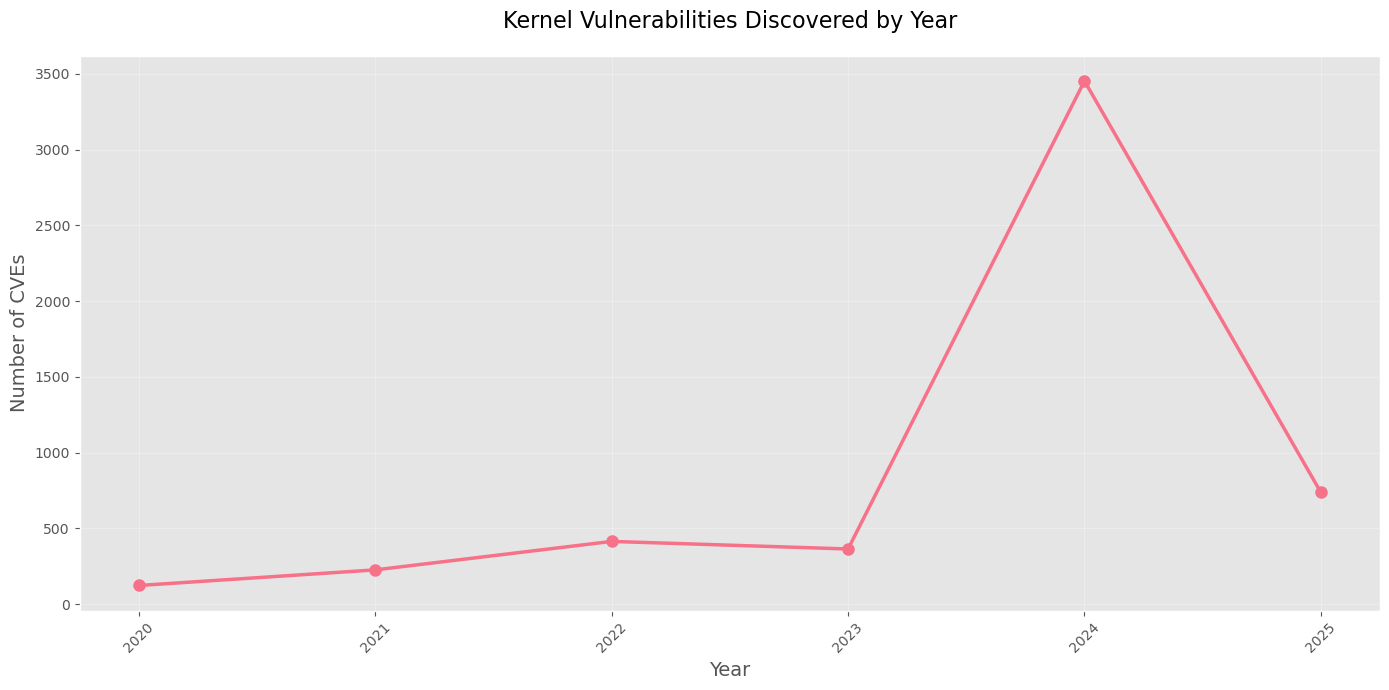

In [43]:
# 1. Temporal Trends (Annual)
plt.figure(figsize=(14, 7))
annual_counts = df.groupby('Year').size()
annual_counts.plot(kind='line', marker='o', linewidth=2.5, markersize=8)
plt.title('Kernel Vulnerabilities Discovered by Year', fontsize=16, pad=20)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of CVEs', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(annual_counts.index, rotation=45)
plt.tight_layout()
plt.show()

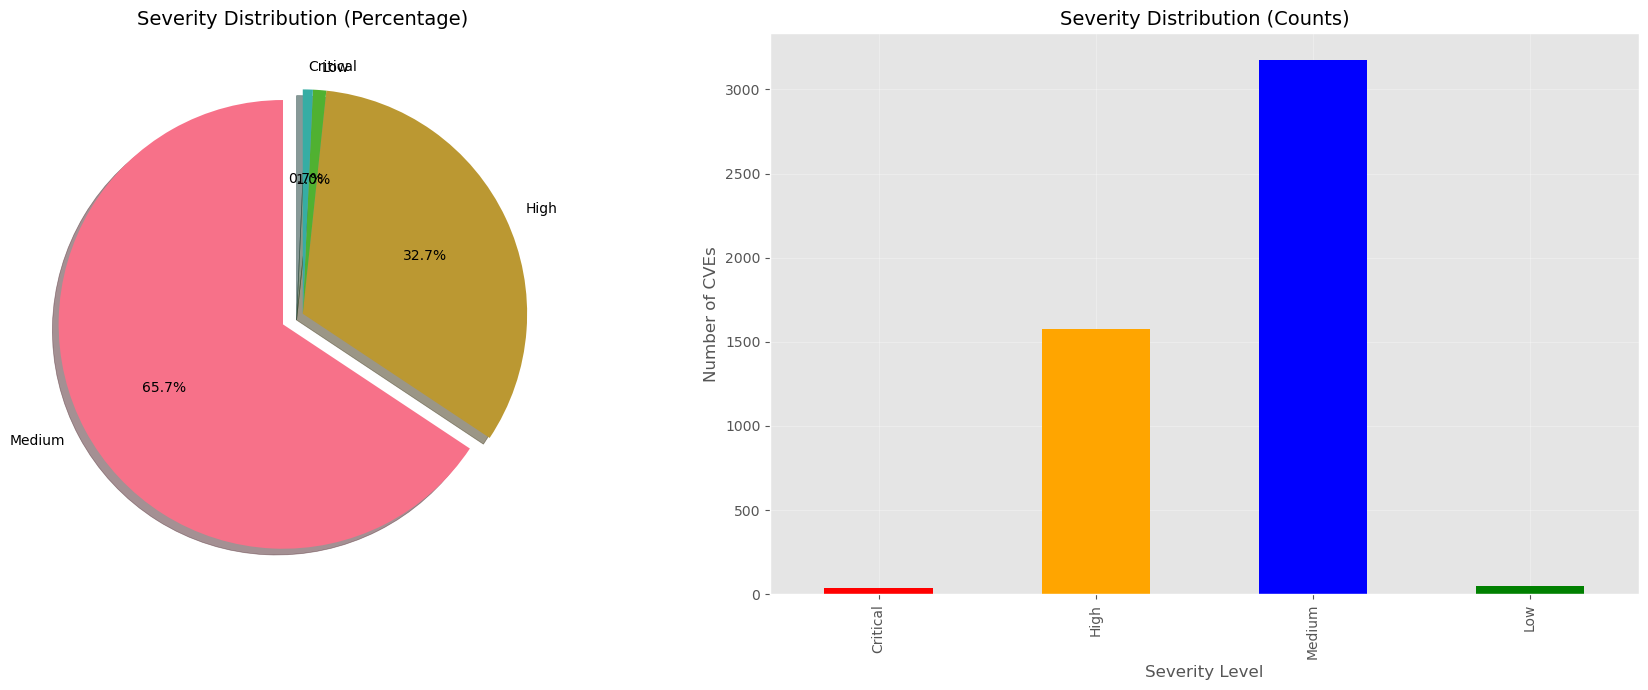

In [45]:
# 2. Severity Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Pie chart
severity_counts = df['Severity_Category'].value_counts()
ax1.pie(severity_counts, labels=severity_counts.index, autopct='%1.1f%%', 
        startangle=90, explode=(0.1, 0, 0, 0), shadow=True)
ax1.set_title('Severity Distribution (Percentage)', fontsize=14)

# Bar chart
severity_order = ['Critical', 'High', 'Medium', 'Low']
severity_counts = df['Severity_Category'].value_counts()[severity_order]
severity_counts.plot(kind='bar', ax=ax2, color=['red', 'orange', 'blue', 'green'])
ax2.set_title('Severity Distribution (Counts)', fontsize=14)
ax2.set_xlabel('Severity Level', fontsize=12)
ax2.set_ylabel('Number of CVEs', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

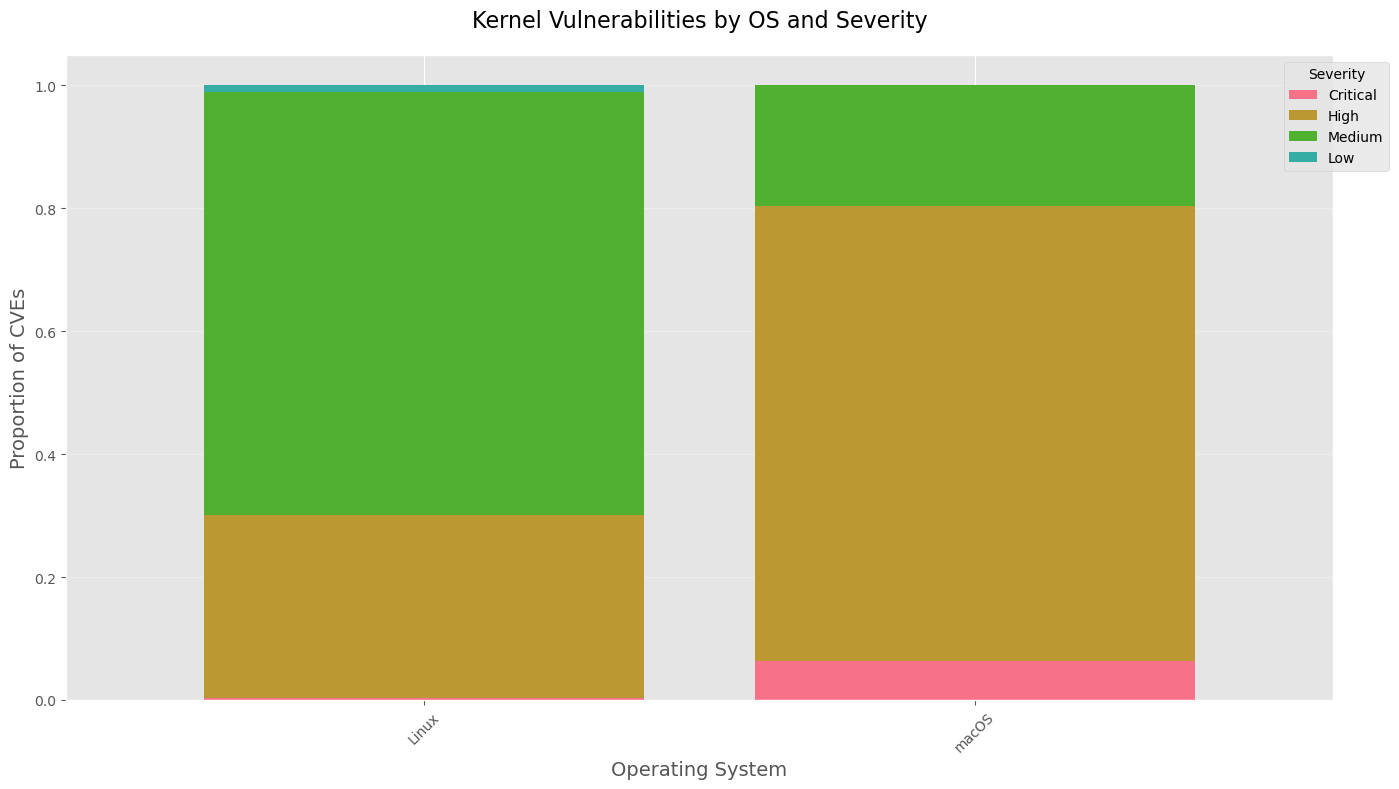

In [47]:
# 3. OS Distribution with Severity Breakdown
plt.figure(figsize=(14, 8))
os_severity = pd.crosstab(df['Affected_OS'], df['Severity_Category'], 
                          values=df['CVE_ID'], aggfunc='count', 
                          normalize='index')

os_severity[severity_order].plot(kind='bar', stacked=True, width=0.8)
plt.title('Kernel Vulnerabilities by OS and Severity', fontsize=16, pad=20)
plt.xlabel('Operating System', fontsize=14)
plt.ylabel('Proportion of CVEs', fontsize=14)
plt.legend(title='Severity', bbox_to_anchor=(1.05, 1))
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/ml/9lq4ld051f5fszn2k_cpc6yh0000gn/T/ipykernel_6465/435378700.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = df.set_index('Published_Date').resample('M').size()


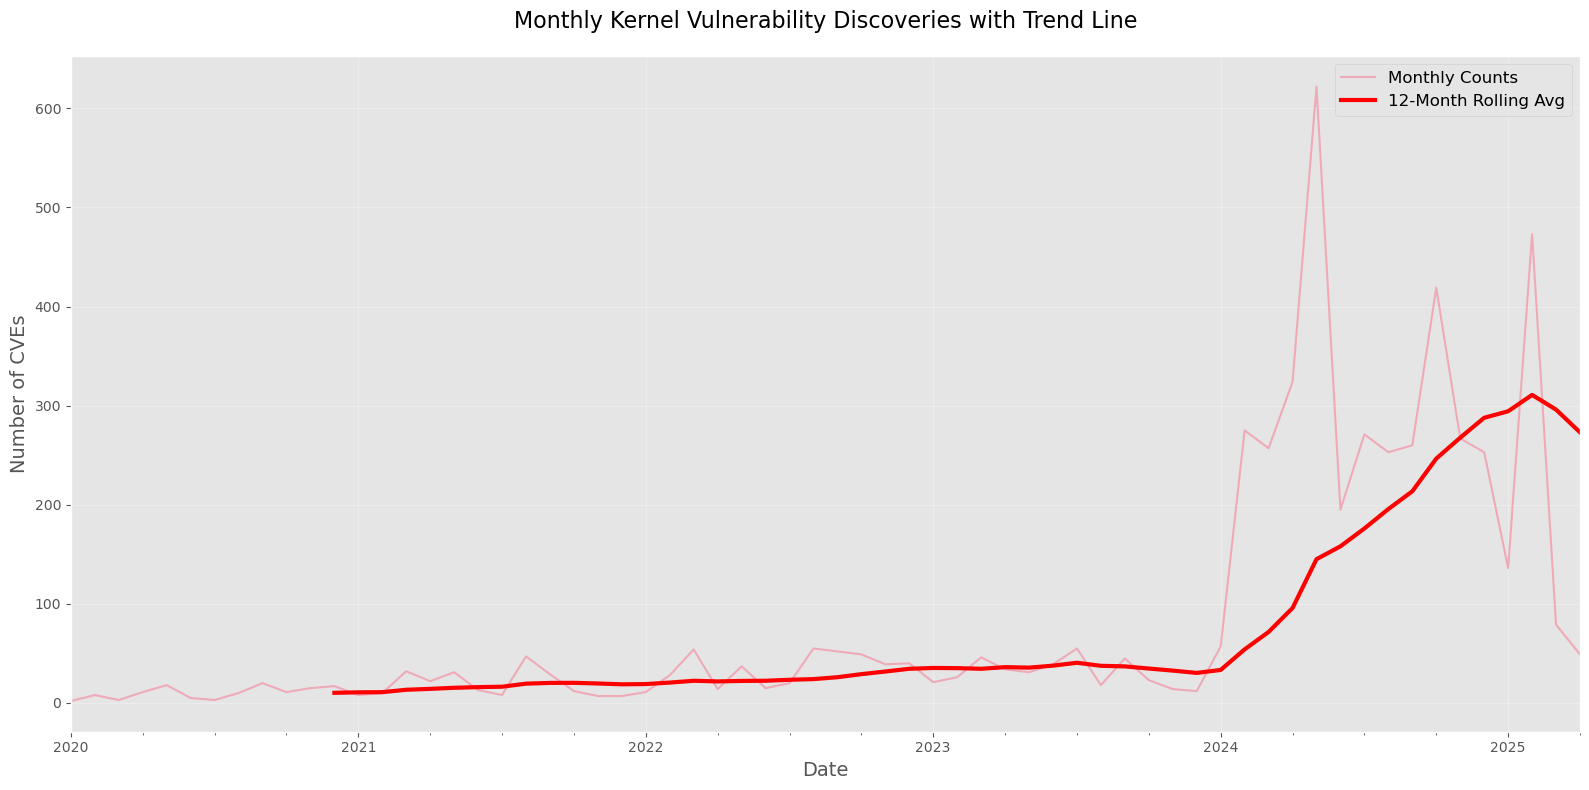

In [49]:
# 4. Monthly Trends with 12-month Rolling Average
plt.figure(figsize=(16, 8))
df['Published_Date'] = pd.to_datetime(df['Published_Date'])
monthly_counts = df.set_index('Published_Date').resample('M').size()
rolling_avg = monthly_counts.rolling(window=12).mean()

ax = monthly_counts.plot(label='Monthly Counts', alpha=0.5)
rolling_avg.plot(label='12-Month Rolling Avg', linewidth=3, color='red')
plt.title('Monthly Kernel Vulnerability Discoveries with Trend Line', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of CVEs', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1600x800 with 0 Axes>

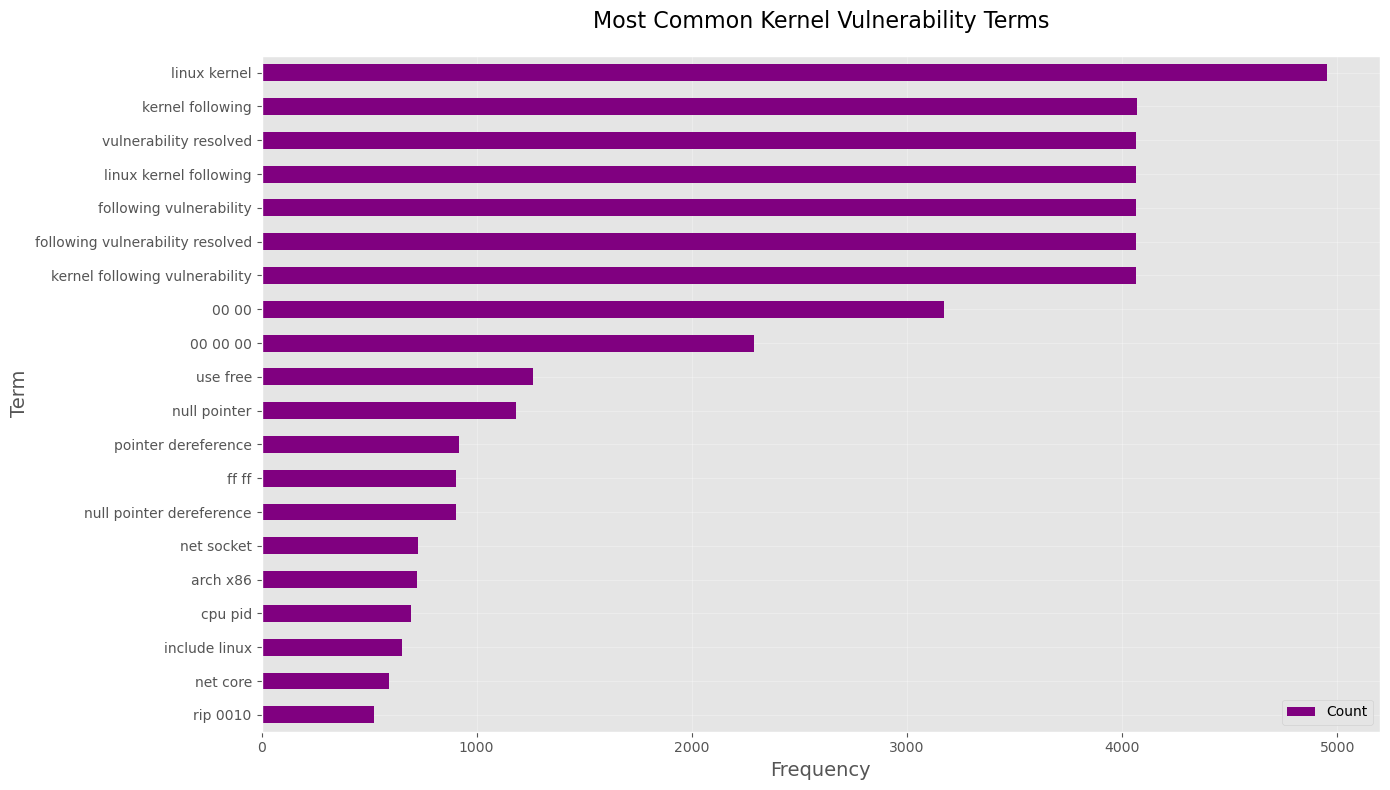

In [51]:
# 5. Vulnerability Terms Visualization
plt.figure(figsize=(16, 8))
text = ' '.join(df['Description'].dropna().str.lower())
vectorizer = CountVectorizer(stop_words='english', ngram_range=(2, 3), max_features=20)
X = vectorizer.fit_transform([text])
word_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).T
word_counts.columns = ['Count']
word_counts.sort_values('Count', ascending=True).plot(kind='barh', color='purple')

plt.title('Most Common Kernel Vulnerability Terms', fontsize=16, pad=20)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Term', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [53]:
# Top 10 Most Severe Vulnerabilities
top_severe = df.nlargest(10, 'CVSS_Score')[['CVE_ID', 'Published_Date', 'CVSS_Score', 'Severity', 'Affected_OS', 'Description']]
print("Top 10 Most Severe Kernel Vulnerabilities:")
display(top_severe)

Top 10 Most Severe Kernel Vulnerabilities:


,CVE_ID,Published_Date,CVSS_Score,Severity,Affected_OS,Description
198,CVE-2021-1829,2021-09-08,9.8,CRITICAL,macOS,A type confusion issue was addressed with impr...
199,CVE-2021-1834,2021-09-08,9.8,CRITICAL,macOS,An out-of-bounds write issue was addressed wit...
273,CVE-2021-30793,2021-09-08,9.8,CRITICAL,macOS,A logic issue was addressed with improved stat...
274,CVE-2021-30805,2021-09-08,9.8,CRITICAL,macOS,A memory corruption issue was addressed with i...
367,CVE-2021-3773,2022-02-16,9.8,CRITICAL,Linux,A flaw in netfilter could allow a network-conn...
420,CVE-2021-43267,2021-11-02,9.8,CRITICAL,Linux,An issue was discovered in net/tipc/crypto.c i...
1087,CVE-2022-22586,2022-03-18,9.8,CRITICAL,macOS,An out-of-bounds write issue was addressed wit...
1088,CVE-2022-22587,2022-03-18,9.8,CRITICAL,macOS,A memory corruption issue was addressed with i...
1199,CVE-2022-32788,2022-09-20,9.8,CRITICAL,macOS,A buffer overflow was addressed with improved ...
1242,CVE-2022-3320,2022-10-28,9.8,CRITICAL,Linux,It was possible to bypass policies configured ...


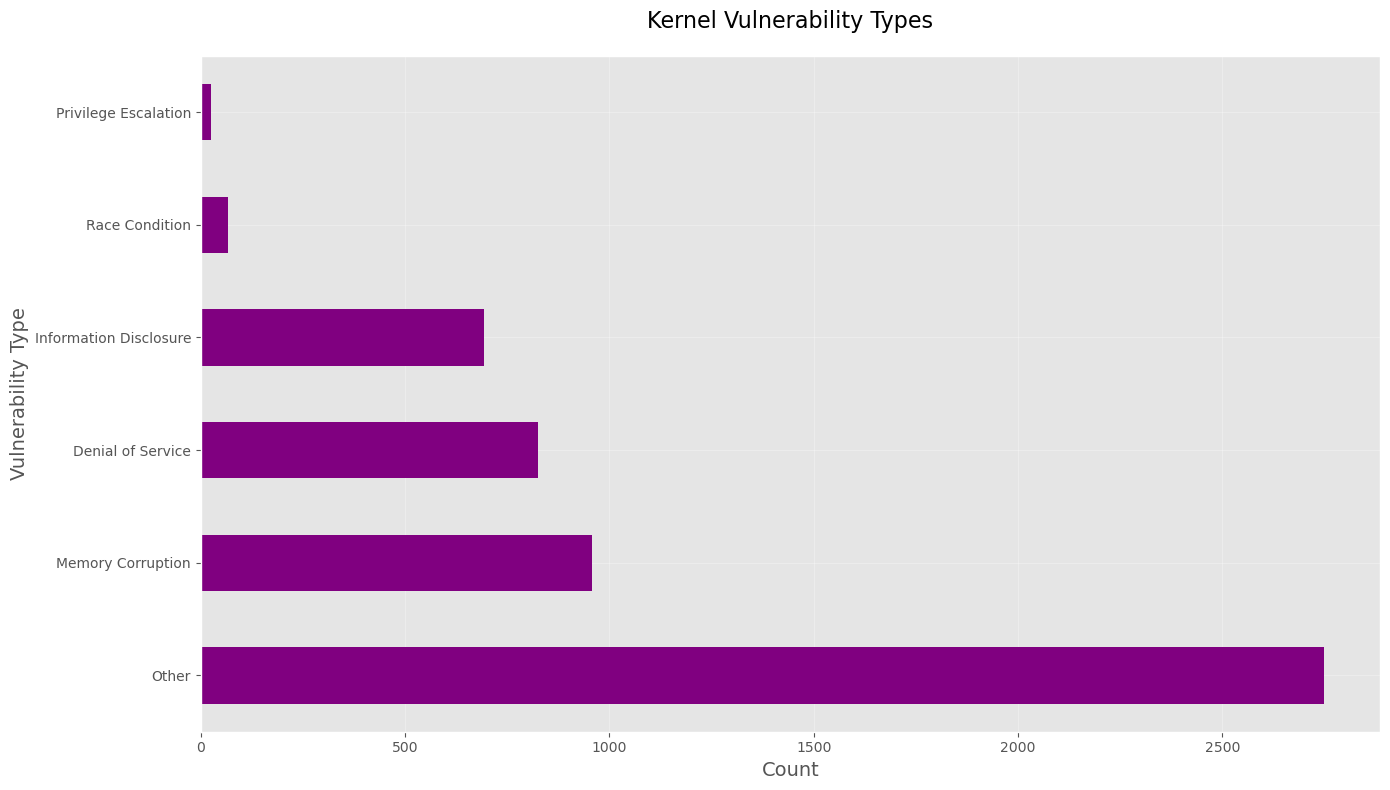

In [55]:
# Vulnerability Type Analysis
# Extract common vulnerability types from descriptions
vuln_types = {
    'Memory Corruption': ['buffer overflow', 'memory corruption', 'use-after-free', 'double free', 'heap overflow'],
    'Privilege Escalation': ['privilege escalation', 'privilege elevation', 'root access', 'admin access'],
    'Information Disclosure': ['information disclosure', 'memory disclosure', 'leak'],
    'Denial of Service': ['denial of service', 'dos', 'crash', 'panic'],
    'Race Condition': ['race condition', 'time-of-check', 'time-of-use']
}

def classify_vulnerability(description):
    desc_lower = description.lower()
    for vuln_type, keywords in vuln_types.items():
        if any(keyword in desc_lower for keyword in keywords):
            return vuln_type
    return 'Other'

df['Vulnerability_Type'] = df['Description'].apply(classify_vulnerability)

# Plot vulnerability types
plt.figure(figsize=(14, 8))
vuln_counts = df['Vulnerability_Type'].value_counts()
vuln_counts.plot(kind='barh', color='purple')
plt.title('Kernel Vulnerability Types', fontsize=16, pad=20)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Vulnerability Type', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [57]:
# Generate summary statistics
total_vulns = len(df)
critical_vulns = len(df[df['Severity_Category'] == 'Critical'])
linux_vulns = len(df[df['Affected_OS'] == 'Linux'])
windows_vulns = len(df[df['Affected_OS'] == 'Windows'])
memory_vulns = len(df[df['Vulnerability_Type'] == 'Memory Corruption'])

print(f"""
Kernel Vulnerability Analysis Results (2020-2025)
-----------------------------------------------
Total Kernel Vulnerabilities: {total_vulns}
Critical Vulnerabilities: {critical_vulns} ({critical_vulns/total_vulns:.1%})

By Operating System:
- Linux: {linux_vulns} ({linux_vulns/total_vulns:.1%})
- Windows: {windows_vulns} ({windows_vulns/total_vulns:.1%})
- macOS: {len(df[df['Affected_OS'] == 'macOS'])} 
- FreeBSD: {len(df[df['Affected_OS'] == 'FreeBSD'])}

Most Common Vulnerability Types:
1. Memory Corruption: {memory_vulns} ({memory_vulns/total_vulns:.1%})
2. {vuln_counts.index[1]}: {vuln_counts[1]} ({vuln_counts[1]/total_vulns:.1%})
3. {vuln_counts.index[2]}: {vuln_counts[2]} ({vuln_counts[2]/total_vulns:.1%})

Trend Analysis:
- Annual growth rate: {(annual_counts.iloc[-1]/annual_counts.iloc[0]-1)*100:.1f}%
- Peak month: {monthly_counts.idxmax().strftime('%B %Y')} ({monthly_counts.max()} vulnerabilities)
""")

# Save processed data
df.to_csv('kernel_vulnerabilities_processed.csv', index=False)
print("Analysis complete. Data saved to kernel_vulnerabilities_processed.csv")


Kernel Vulnerability Analysis Results (2020-2025)
-----------------------------------------------
Total Kernel Vulnerabilities: 5317
Critical Vulnerabilities: 35 (0.7%)

By Operating System:
- Linux: 4992 (93.9%)
- Windows: 0 (0.0%)
- macOS: 325 
- FreeBSD: 0

Most Common Vulnerability Types:
1. Memory Corruption: 958 (18.0%)
2. Memory Corruption: 958 (18.0%)
3. Denial of Service: 826 (15.5%)

Trend Analysis:
- Annual growth rate: 499.2%
- Peak month: May 2024 (622 vulnerabilities)

Analysis complete. Data saved to kernel_vulnerabilities_processed.csv


/var/folders/ml/9lq4ld051f5fszn2k_cpc6yh0000gn/T/ipykernel_6465/2644875865.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  2. {vuln_counts.index[1]}: {vuln_counts[1]} ({vuln_counts[1]/total_vulns:.1%})
/var/folders/ml/9lq4ld051f5fszn2k_cpc6yh0000gn/T/ipykernel_6465/2644875865.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  3. {vuln_counts.index[2]}: {vuln_counts[2]} ({vuln_counts[2]/total_vulns:.1%})
